<a href="https://colab.research.google.com/github/anilkeshwani/StatLearnProj/blob/master/Iason/Word2Vec_Pretrained_Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import json
import random
from tqdm import tqdm,tqdm_notebook
import enchant
from nltk import everygrams

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MaxAbsScaler,MinMaxScaler
from sklearn.model_selection import train_test_split,GridSearchCV,KFold,RandomizedSearchCV
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_score,recall_score,f1_score,make_scorer,fbeta_score
from sklearn.metrics import average_precision_score,plot_precision_recall_curve,precision_recall_curve
from sklearn.metrics import roc_auc_score,roc_curve, auc

from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

from sklearn.decomposition import PCA

import clean_text as ct
from gensim.models import KeyedVectors, Word2Vec
from sklearn.linear_model import LogisticRegression

In [ ]:
tweets = pd.read_csv('climate_change_tweets_sample-2020-05-16-17-57.csv')
tweets.head()

,username,user_handle,date,retweets,favorites,text,label
0,WWF Climate & Energy,climateWWF,2020-04-28,11,22,Economic recovery and national climate pledges...,0
1,WWF Climate & Energy,climateWWF,2020-04-22,6,16,"In this difficult time, it’s hard to connect w...",0
2,WWF Climate & Energy,climateWWF,2020-04-01,43,69,"The decision to postpone # COP26, is unavoidab...",0
3,WWF Climate & Energy,climateWWF,2020-03-30,24,30,Japan - the world’s fifth largest emitter of g...,0
4,WWF Climate & Energy,climateWWF,2020-03-30,22,40,How can countries include # NatureBasedSolutio...,0


In [ ]:
clean_text = ct.CleanText()
tweets["text"] = clean_text.transform_no_stem(tweets.text)
tweets = tweets.loc[(~tweets.text.isnull()), :]
tweets.head()

,username,user_handle,date,retweets,favorites,text,label
0,WWF Climate & Energy,climateWWF,2020-04-28,11,22,economic recovery national climate pledges mus...,0
1,WWF Climate & Energy,climateWWF,2020-04-22,6,16,difficult time hard connect natural world eart...,0
2,WWF Climate & Energy,climateWWF,2020-04-01,43,69,decision postpone cop unavoidable collective p...,0
3,WWF Climate & Energy,climateWWF,2020-03-30,24,30,japan worlds fifth largest emitter greenhouse ...,0
4,WWF Climate & Energy,climateWWF,2020-03-30,22,40,countries include naturebasedsolutions climate...,0


#### Embedder

In [ ]:
###you have to download the pre-trained vectorizer at: https://fasttext.cc/docs/en/english-vectors.html

model = 'wiki-news-300d-1M.vec'

model_emb = KeyedVectors.load_word2vec_format(model, binary=False)

# import gensim.downloader as api
# model_emb = api.load(model)

In [ ]:
unvectorizable = set()
all_words = set()


def Word2VectorizeTweet(tweet):
    global all_words
    global unvectorizable
    
    tweet_vector = np.zeros(shape=(300,), dtype="float32")
    n_vectorizable = 0
    
    for word in tweet.split():
        try:
#             print(f"Adding {word} to word representation")
            tweet_vector = np.add(tweet_vector, model_emb.get_vector(word))
            all_words.add(word)
            n_vectorizable += 1
        except KeyError:
            d = enchant.Dict("en_US")
            words = [''.join(_ngram) for _ngram in everygrams(word) if d.check(''.join(_ngram)) and len(_ngram) > 1]
            if len(words) == 0:
                if word not in unvectorizable:
                    #print(f"Could not vectorize {word}")
                    unvectorizable.add(word)
            else:
                for w in words:
                    try:
                        tweet_vector = np.add(tweet_vector, model_emb.get_vector(w))
                        all_words.add(w)
                        n_vectorizable += 1
                    except KeyError:  
                        if w not in unvectorizable:
                            #print(f"Could not vectorize {w}")
                            unvectorizable.add(w)
    return (tweet_vector/n_vectorizable)

In [ ]:
tqdm.pandas(tqdm_notebook)
tweets["FastText"] = tweets.text.progress_apply(func=Word2VectorizeTweet)

100%|████████████████████████████████████████████████████████████████████████████| 18009/18009 [05:03<00:00, 59.27it/s]


In [ ]:
print(unvectorizable)

{'urger', 'migrator', 'macing', 'insp', 'eyer', 'hemmer', 'shanny', 'gamb', 'verbid', 'lovelock', 'brei', 'latten', 'luntz', 'gcb', 'ersh', 'troys', 'airt', 'erne', 'wwfsg', 'lwei', 'hypoth', 'strati', 'grig', 'wmnf', 'taction', 'izzard', 'logiest', 'obstructor', 'dinge', 'fth', 'retrad', 'xrnyc', 'inorg', 'djf', 'rehi', 'cered', 'algor', 'cnni', 'teleg', 'eddo', 'ticals', 'stoss', 'oping', 'surv', 'olid', 'delayers', 'sociol', 'uwp', 'akene', 'inkles', 'responser', 'terf', 'ctn', 'tyg', 'rooking', 'keas', 'kier', 'illation', 'epw', 'csch', 'djt', 'lustrate', 'linin', 'tingler', 'wlrn', 'argol', 'hyla', 'illations', 'loq', 'bigeyes', 'igcz', 'scorner', 'smatter', 'instancy', 'unhq', 'undp', 'gean', 'haler', 'spicer', 'snc', 'rugging', 'zens', 'milden', 'paralyzingly', 'wwfepo', 'ecol', 'hent', 'kxl', 'qts', 'manhattans', 'lacier', 'ankus', 'alee', 'wwfs', 'ayins', 'beths', 'blackheart', 'kyte', 'seiu', 'propr', 'pottiest', 'omber', 'furn', 'neral', 'cyclings', 'obb', 'cnns', 'thebe', '

In [ ]:
print(tweets.shape)

(18009, 8)


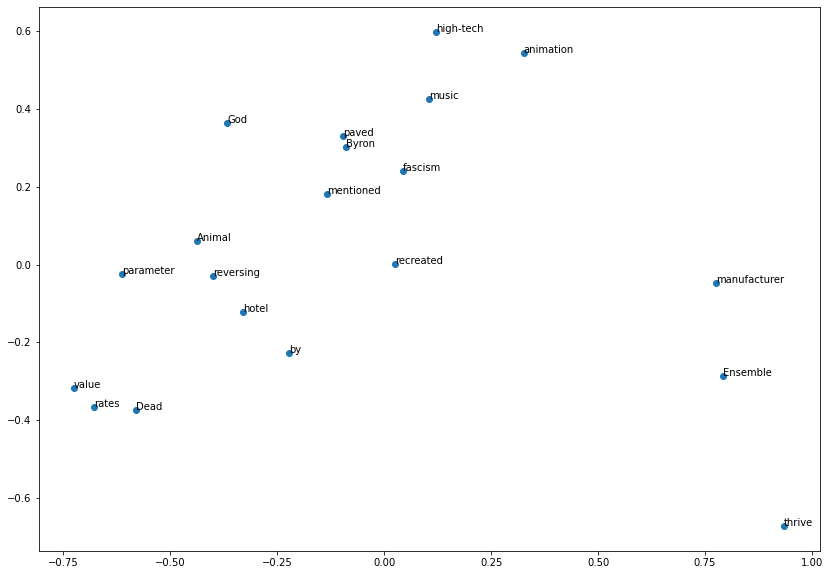

In [ ]:
plt.figure(figsize=(14, 10))

res = random.sample(range(1, len(all_words)), 20) 

vocab = model_emb[all_words]
pca = PCA(n_components=2)
pca_results = pca.fit_transform(vocab)

plt.scatter(pca_results[res, 0], pca_results[res, 1])

words = list(model_emb.vocab)

for i, word in enumerate(words):
    if i in res:
        plt.annotate(word[:], xy=(pca_results[i, 0], pca_results[i, 1]))
plt.show()

#### Remove NaN

In [ ]:
print(tweets.shape)
tweets['FastTextNan'] = tweets['FastText']
tweets['FastTextNan'] = np.array([k.tolist() for k in tweets.FastText.values]) 
print(tweets.shape)

(18009, 8)
(18009, 9)


In [ ]:
print(tweets.shape)

tweets.dropna(inplace=True)

print(tweets.shape)

(18009, 9)
(18008, 9)


### Training of the Model

In [ ]:
X = np.array([k.tolist() for k in tweets.FastText.values])

X_train, X_test, y_train, y_test = train_test_split(X, tweets.label.values, 
                                                    test_size=0.2, random_state=17, 
                                                    shuffle=True) # explicit default

#[print(dat[:3], dat.shape, end="\n"*2) for dat in [X_train, X_test, y_train, y_test]];



In [ ]:
X_train.shape

(14406, 300)

In [ ]:
params = {'C':1, 'max_iter':1000, 'multi_class' :"ovr", 'solver':'saga'}


model = LogisticRegression(**params) # use all CPUs

model.fit(X_train, y_train)

LogisticRegression(C=1, max_iter=1000, multi_class='ovr', solver='saga')

In [ ]:
pred = model.predict(X_test)

accuracy = accuracy_score(y_test,pred)
precision = precision_score(y_test,pred)
recall = recall_score(y_test,pred)
f0_5 = fbeta_score(y_test,pred,beta=0.5)
f1 = f1_score(y_test,pred)
f2 = fbeta_score(y_test,pred,beta=2)

print('Accuracy: {}'.format(round(accuracy,4)))
print('Precision: {}'.format(round(precision,4)))
print('Recall: {}'.format(round(recall,4)))
print('F0_5_score: {}'.format(round(f0_5,4)))
print('F1_score: {}'.format(round(f1,4)))
print('F2_score: {}'.format(round(f2,4)))

Accuracy: 0.8723
Precision: 0.8954
Recall: 0.8887
F0_5_score: 0.894
F1_score: 0.892
F2_score: 0.89


Average precision-recall score: 0.94


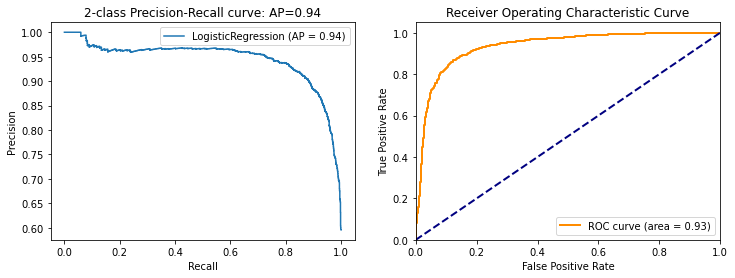

In [ ]:
y_score = model.predict_proba(X_test)[:, 1]
average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

fig, axes = plt.subplots(figsize=(12,4),nrows=1,ncols=2)
disp = plot_precision_recall_curve(model, X_test, y_test,ax=axes[0])
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))
axes[0].legend(loc="upper right")


fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

#plt.figure()
lw = 2
axes[1].plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
axes[1].plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Receiver Operating Characteristic Curve')
axes[1].legend(loc="lower right")
plt.show()